In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy
import time

from funcs.model import (full_model,
                         aflare,
                         calculate_specific_flare_flux,
                         calculate_angular_radius)
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve


CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve


# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 6, # one flare, one active region
             "log_probability_2flares": 9, # two flares, one active region
            }

# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


In [36]:
tstamp

'13_10_2020_13_08'

In [39]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 1
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

# Pick up quiescent luminosity
qlum = target.tlum * u.erg/u.s

# Pick up stellar radius
R = target.rad * R_sun

target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
GRP                                NaN
plxmas                             NaN
eplxmas                            NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                

In [85]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.0) & (t < target.view_stop-.4) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02


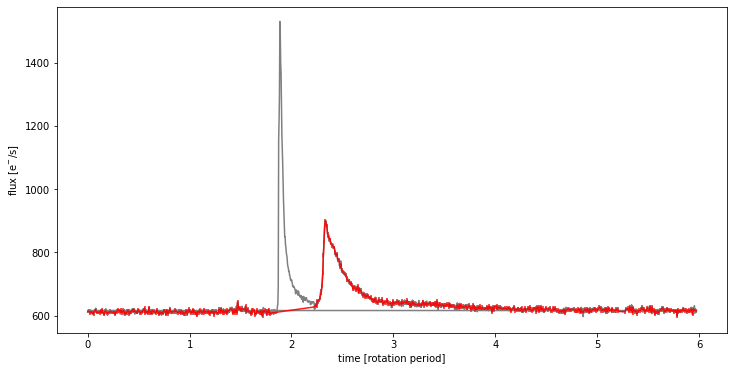

In [98]:

cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
cff = cff[(cff.phi<1.8*2*np.pi) |(cff.phi>2.225*2*np.pi)]
plt.figure(figsize=(12,6))
plt.plot(cf.phi/(2*np.pi), cf.flux,color="grey")
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.plot(cf.phi/(2*np.pi), [median]*len(cf.phi),color="grey")

plt.xlabel("time [rotation period]")
plt.ylabel(r"flux [e$^{-}$/s]");
#plt.xlim(25,30)

In [99]:
#cff = cff[(cff.phi<18.7) |(cff.phi>19.6)]
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.0375, 0.0417]",0.012423,613.633232,1331.001750,5.800927,616.539031
"(0.0417, 0.0834]",0.062113,615.144127,1331.004528,5.800927,616.539031
"(0.0834, 0.125]",0.111803,612.218333,1331.007306,5.800927,616.539031
"(0.125, 0.167]",0.149070,609.168448,1331.009390,5.800927,616.539031
"(0.167, 0.209]",0.186338,613.051801,1331.011473,5.800927,616.539031
...,...,...,...,...,...
"(37.332, 37.374]",37.354540,621.576389,1333.089293,5.800927,616.539031
"(37.374, 37.416]",37.391808,616.293308,1333.091377,5.800927,616.539031
"(37.416, 37.457]",37.429075,619.798831,1333.093460,5.800927,616.539031


In [100]:
# Write out light curve to use for MCMC fit
cff = cff.dropna(how="any")
cff.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [101]:
tstamp

'13_10_2020_13_08'

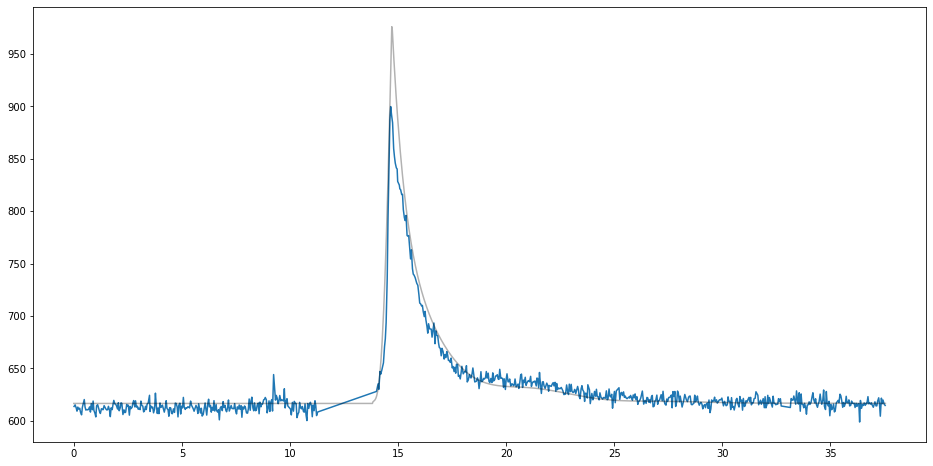

In [105]:
# Play with parameters to get a first guess for the MCMC 
# When fitting more than one flare, do one flare first, then the next etc.

# Flare peak time
phi_a =11.83

# Active region latitude
theta_a = 40.2959564620278 / 180 * np.pi

# Flare amplitude
a = 2.82553675464244

# 2*FWHM of flare
fwhm =  0.02402343971409 / target.Prot_d * np.pi *2 


phi0 =4.


phi_a, a, theta_a, fwhm, phi0 =  14.71592183677561, 0.7142289688195725, 1.0036986666259009, 1.7549310136349876, -2.8811279286762677

Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius

plt.figure(figsize=(16,8))
plt.plot(cff.phi,cff.flux)
# for i in np.linspace(-2*np.pi,2*np.pi,10):
#     plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=.3,);
# plt.xlim(1331,1333.25)
#plt.ylim(608,900)

In [34]:
# Choose model:
log_prob = "log_probability"#_2flares"
nparam = log_probs[log_prob]


# Save starting points and parameters for MCMC
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)